In [1]:
import numpy as np
from scipy.stats import describe
import matplotlib.pyplot as plt
from tqdm import tqdm

import seaborn as sns

sns.set(context="talk", color_codes=True)

from lvmdrp.core import image
from lvmdrp.functions import imageMethod
from lvmdrp.utils import database
from lvmdrp.utils import bitmask

from lvmdrp.main import load_master_config

In [2]:
config = load_master_config()

db = database.create_or_connect_db(config)

raw_flats = database.LVMFrames.select().where(
    (database.LVMFrames.imagetyp == "flat") &
    (database.LVMFrames.status == bitmask.ReductionStatus["RAW"]) &
    (database.LVMFrames.flags == bitmask.QualityFlag["OK"])
).order_by(database.LVMFrames.exptime.asc())

In [3]:
# for each flat frame
    # 	read raw frame
    #   remove overscan regions
    # 	split into amplifiers
    # 	for each amplifier
    #	 	calculate statistics (mean, variance, median, kurt, skew)
    # 		decide which frames/amplifiers go into gain calculation based in skew and kurt
    # plot sigma_counts vs sqrt(mean_counts)
    # fit slope

N_FLATS = raw_flats.count()
mean, sdev = {amp: np.zeros(N_FLATS) for amp in "abcd"}, {amp: np.zeros(N_FLATS) for amp in "abcd"}
skew, kurt = {amp: np.zeros(N_FLATS) for amp in "abcd"}, {amp: np.zeros(N_FLATS) for amp in "abcd"}
exptimes = np.zeros(N_FLATS)
for j, raw_flat in tqdm(enumerate(raw_flats), total=N_FLATS, desc="fetching raw flats", unit="frame", ascii=True):

    flat = image.loadImage(raw_flat.path)
    ab, cd = flat.split(2, axis="Y")
    (a, b), (c, d) = ab.split(2, axis="X"), cd.split(2, axis="X")
    # reflect b and d amplifiers to have the overscan regions in the last columns
    b.orientImage("X")
    d.orientImage("X")
    amps = [a, b, c, d]
    for i, (amp_name, amp) in enumerate(zip(mean.keys(), amps)):
        amps[i].cutOverscan(("1","2040"), ("1","2040"), subtract=False)
        stats = describe(amps[i]._data, axis=None)
        mean[amp_name][j] = stats.mean
        sdev[amp_name][j] = np.sqrt(stats.variance)
        kurt[amp_name][j] = stats.kurtosis
        skew[amp_name][j] = stats.skewness

fetching raw flats: 100%|##########| 1140/1140 [13:16<00:00,  1.43frame/s]


Text(0, 0.5, '$\\hat{F}_\\mathrm{ADU}$')

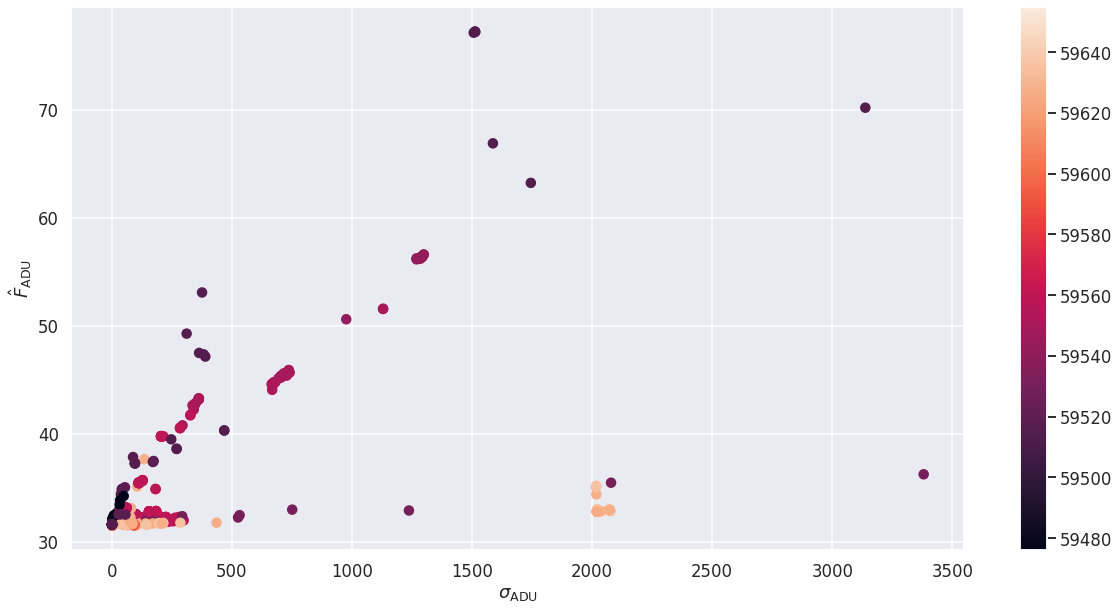

In [4]:
exptimes = np.asarray([raw_flat.exptime for raw_flat in raw_flats])
mjd = np.asarray([raw_flat.mjd for raw_flat in raw_flats])
exptimes /= exptimes.max()

x, y = sdev["a"], np.sqrt(mean["a"])
mask = (y<np.sqrt(6000))&(exptimes<250)

plt.figure(figsize=(20,10))
plt.scatter(x[mask], y[mask], c=mjd[mask])
plt.colorbar()
plt.xlabel(r"$\sigma_\mathrm{ADU}$")
plt.ylabel(r"$\hat{F}_\mathrm{ADU}$")